**Construyendo una Red Neuronal (NN) para predecir el tiempo de lluvia mediante un modelo con datos reales**

Para llevar a cabo esta tarea:
- Se pre-procesarán archivos CSV y se convertirán los datos en tensores
- Se construirá un modelo de NN con PyTorch
- Se usará una funcion de pérdida (loss function) y un optimizador para entrenar el modelo
- Se evaluará el modelo y se reconoceran los peligros de una clasificacion desequilibrada.

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy : 1.21.5
pandas: 1.3.5
torch : 1.10.0+cu111



In [4]:
#Dependencias
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Datos

Subir el dataset (Datos de multiples estaciones climaticas de Australia) al notebook. Los datos se encuentran en Kaggle (Joe Young, Rain in Australia):
https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [5]:
df = pd.read_csv('/content/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Vamos a hacer un primer acercamiento con los datos ya que por ejemplo se ven muchos NaN

In [6]:
df.shape

(145460, 23)

**Procesando los Datos**

Simplificaremos el Set y solo se tomarán en cuenta 5 columnas que estan relacionadas con la pregunta que se quiere resolver: ¿va a llover o no el día de mañana?

In [7]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Las **redes neuronales** solo funcionan con numeros así que se convertiran los **Si** en **1** y los **No** en **0**

In [8]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

Se descartan tambien las filas con valores faltantes(NaN)

In [9]:
df = df.dropna(how='any')
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0


**Teniendo los datos listos toca ver si estan equilibrados (misma proporción) de cuantas veces llovió o no "mañana"**, graficamos para poder verlo:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


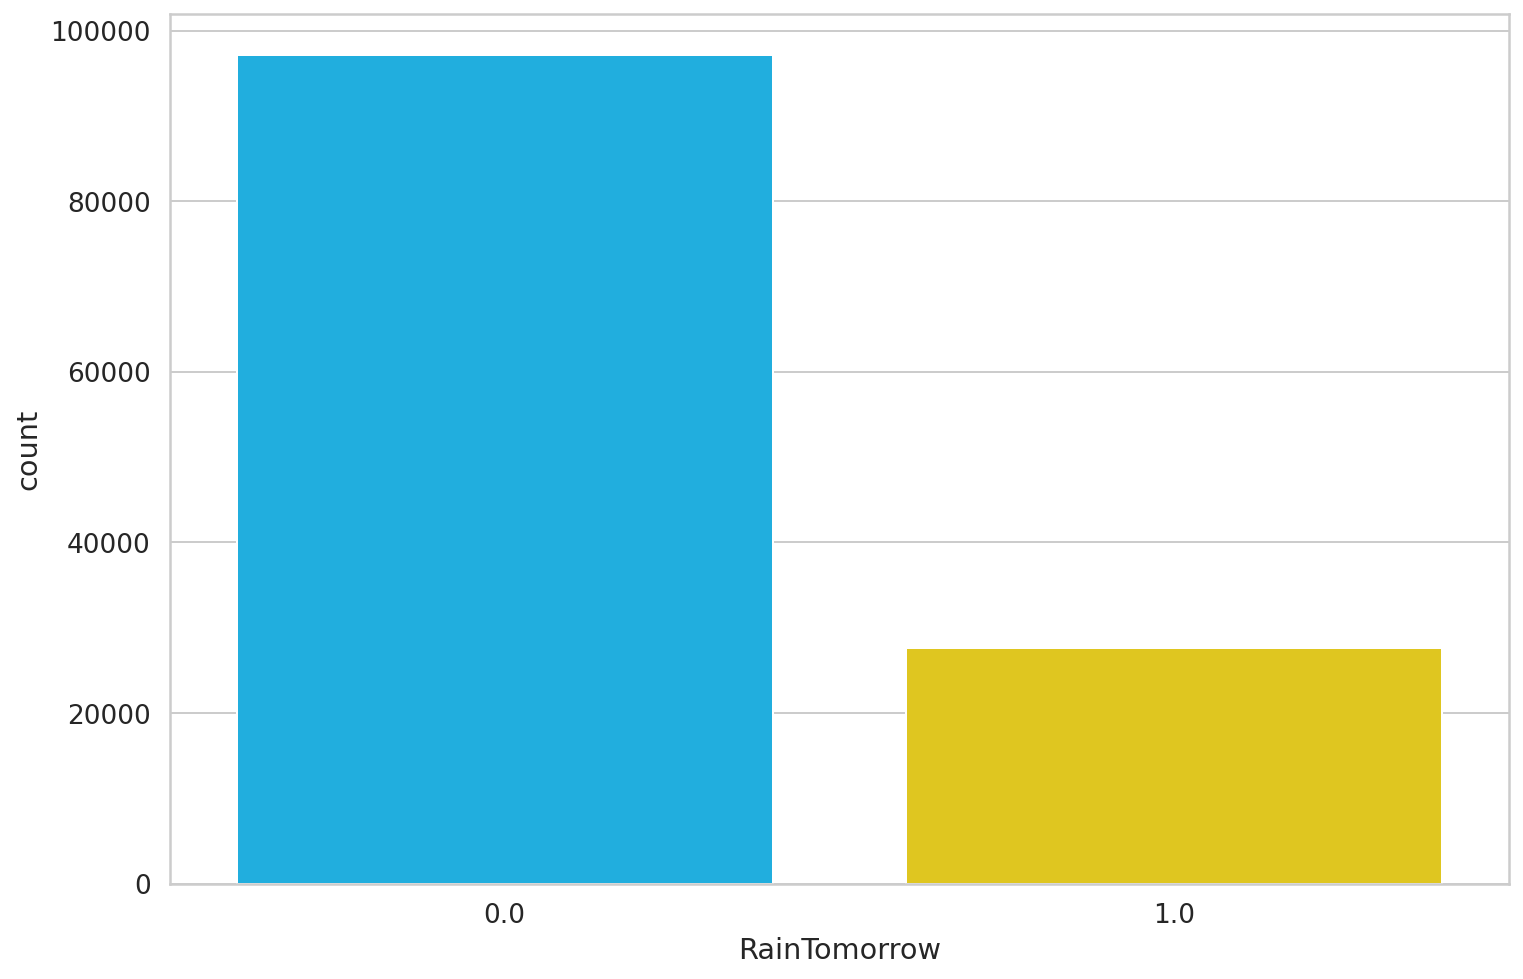

In [10]:
sns.countplot(df.RainTomorrow);

In [11]:
df.RainTomorrow.value_counts() / df.shape[0]

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

La cosa no pinta bien, alrrededor de un 78% tienen que no lloverá mañana (RainTomorrow). Esto quiere decir que habrá un 78 de ventaja de que no lloverá mañana. Los pesos (weights) seran diferentes.

Cuando se presenta este problema toca tener en cuenta alguna guía para manejar datos desequilibrados. Lo ideal es que fueran 50-50. El objetivo en este notebook es crear una red neuronal por lo que dejaremos los datos así, sin embargo esto es para tener en cuenta y poder entrenar modelos confiables.

Despues de esta aclaracion se dividen los datos de entrenamiento y prueba

In [12]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

.... y se convierten en tensores, aca entra a trabajar PyTorch

In [13]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


**Construyendo la Red Neuronal**

- Los datos de Entrada (input) seran: *Rainfall, Humidity3pm, RainToday, Pressure9am.* Se crea una capa de entrada apropiada para este conjunto de datos.
- El resultado o datos de Salida (output) será un número entre 0 y 1 que representa la probabilidad de que llueva mañana (RainTomorrow). La predicción la dará la capa final (de salida) de la red.
- Agregaremos dos capas ocultas (hidden layer 1 & 2) entre las capas de entrada y salida. Los parámetros (neuronas) de esas capas decidirán el resultado final. Todas las capas estarán completamente conectadas.
Una manera fácil de construir el NN con PyTorch es crear una clase que herede el *torch.nn.Module:*



In [14]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

Comenzamos creando las capas de nuestro modelo en el constructor. El método **forward()** es donde ocurre la magia. Acepta la entrada **x** y permite que fluya a través de cada capa.

Hay un paso hacia atrás correspondiente (definido automaticamente por PyTorch) que permite que el modelo aprenda de los errores que está cometiendo actualmente.

**Funciones de Activacion (Activation Functions)**

Es posible que observe las llamadas a **F.relu** y **torch.sigmoid.** ¿Por qué las necesitamos?

Una caracteristica interesante de las redes neuronales es que **pueden aproximar funciones no lineales**. De hecho, está probado que pueden aproximarse a cualquier función.

Buena suerte aproximando funciones no lineales apilando capas lineales. Las funciones de activación permiten romper con el mundo lineal y aprender más. Por lo general, las encontrará aplicadas a una salida de alguna capa.

>Se puede profundizar por ejemplo con **ReLU** que es una de las funciones de activacion mas usadas
$$ ReLU(x)=max(0,x)$$

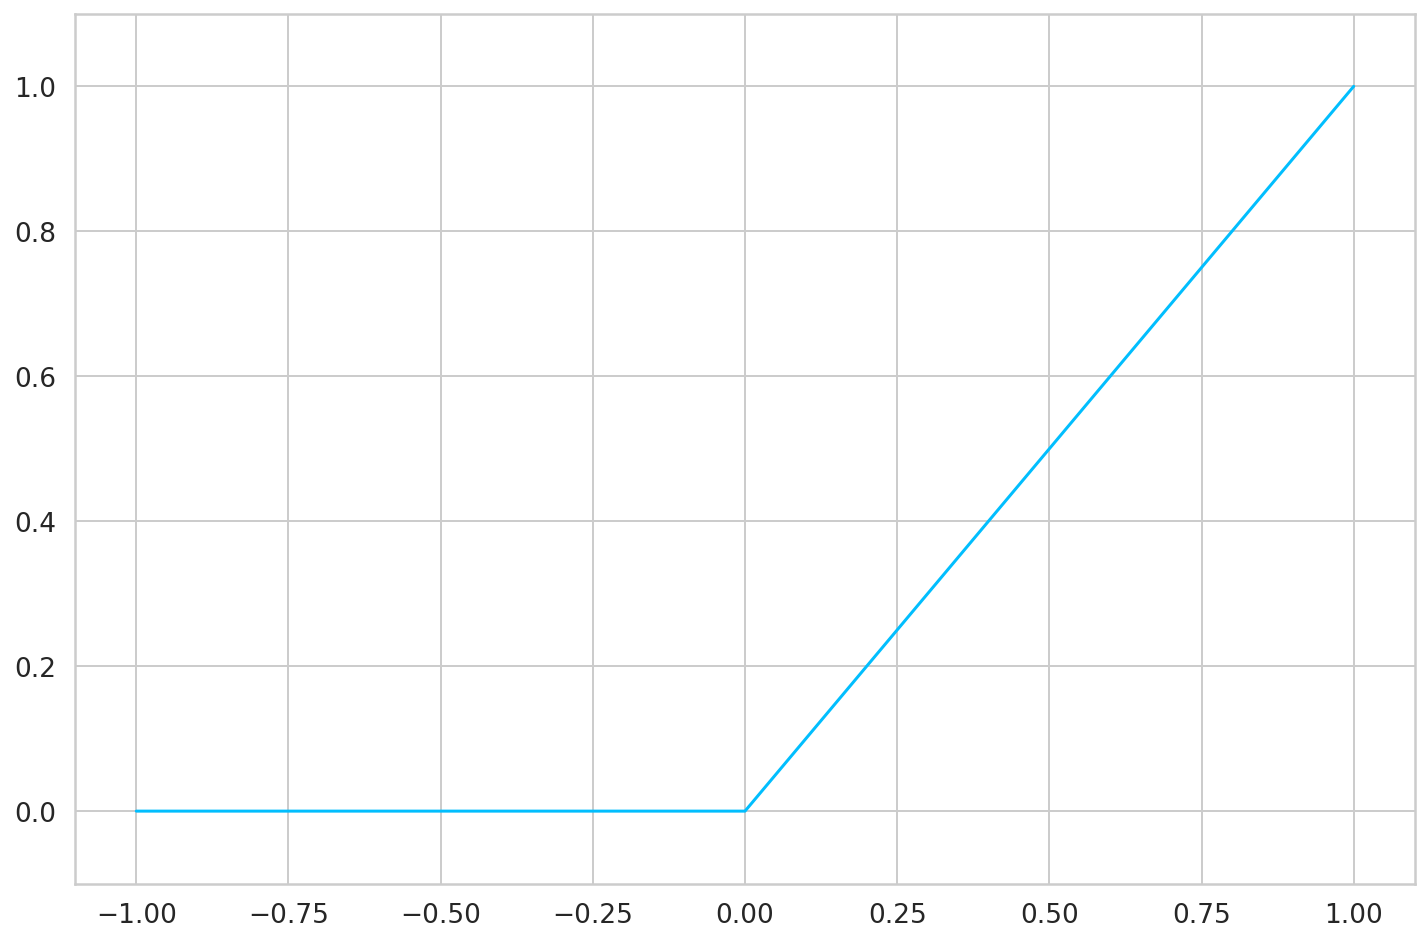

In [16]:
ax = plt.gca()

plt.plot(
  np.linspace(-1, 1, 5), 
  F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

SIGMOIDEO (Sigmoid)

El sigmoide es útil cuando necesita tomar una decisión/clasificación binaria (responder con un sí o un no).

Se define como:
$$Sigmoid(x)=1/1+e−x$$

El sigmoide aplasta los valores de entrada entre 0 y 1 pero de una manera "amable".

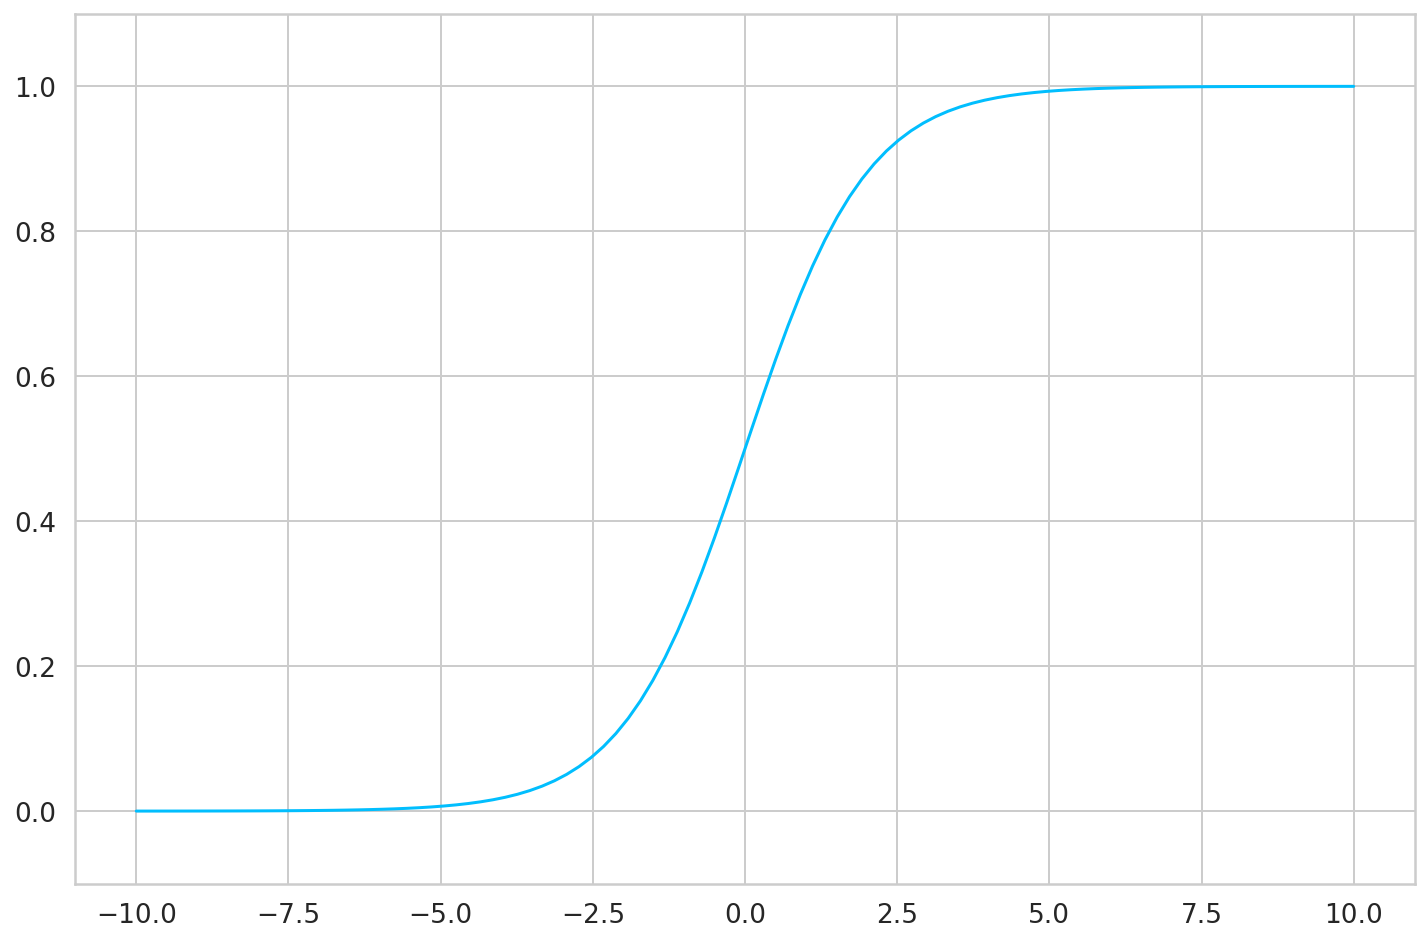

In [17]:
ax = plt.gca()

plt.plot(
  np.linspace(-10, 10, 100), 
  torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

**El Entreno, entrenamiento o Training del modelo**

Con el modelo implementado, necesitamos encontrar parámetros que predigan si lloverá mañana. Primero, necesitamos algo que nos diga qué tan bien lo estamos haciendo actualmente:

In [18]:
criterion = nn.BCELoss()

**BCELoss** es una función de pérdida que mide la diferencia entre dos vectores binarios. En nuestro caso, las predicciones de nuestro modelo y los valores reales. Espera que los valores sean generados por la función sigmoidea. Cuanto más se acerque este valor a 0, mejor debería ser su modelo.

Pero, ¿cómo encontramos parámetros que minimicen la función de pérdida?

**Optimización**

Imaginemos que cada parámetro de nuestro NN es una perilla. El trabajo del optimizador es encontrar las posiciones perfectas para cada perilla para que la pérdida se acerque a 0.

Los modelos del mundo real pueden contener millones o incluso miles de millones de parámetros. Con tantas perillas para girar, sería bueno tener un optimizador eficiente que encuentre soluciones rápidamente.

Al contrario de lo que pueda creer, la optimización en Deep Learning es simplemente satisfactoria. En la práctica, se contenta con valores de parámetros suficientemente buenos que le den una precisión aceptable.

Si bien hay toneladas de optimizadores entre los que puede elegir, Adam es una primera opción segura. PyTorch tiene una implementación bien depurada que puede usar:

In [19]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

Naturalmente, el optimizador requiere los parámetros. El segundo argumento **lr** es la tasa de aprendizaje. Es una compensación entre qué tan buenos parámetros vamoa a encontrar y qué tan rápido llegaremos allí.

**Haciéndolo en la GPU (de colab)**

Para usar una GPU en colab ir al entorno de ejecucion y cambiar el tipo de **ninguna** por **GPU**

Hacer cálculos paralelos masivos en GPU es uno de los habilitadores del aprendizaje profundo (Deep Learning) moderno.

PyTorch hace que sea muy fácil transferir todos los cálculos y datos a una GPU:

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [22]:
net = net.to(device)

criterion = criterion.to(device)

Comenzamos comprobando si un dispositivo CUDA está disponible o no. Luego, transferimos todos los datos de entrenamiento y prueba a ese dispositivo. Finalmente, movemos nuestro modelo y función de pérdida.

**Pronostico del tiempo**

Tener una función de pérdida es excelente, pero rastrear la precisión de nuestro modelo. Aquí está la definición de nuestra precisión:

In [23]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

Convertimos todos los valores por debajo de 0,5 a 0. De lo contrario, lo establecemos en 1. Finalmente, calculamos el porcentaje de valores correctos.

**Con todas las piezas del rompecabezas podemos comenzar a entrenar a nuestro modelo:**

In [24]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100
Train set - loss: 0.457, accuracy: 0.792
Test  set - loss: 0.458, accuracy: 0.793

epoch 200
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.436, accuracy: 0.8

epoch 300
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.421, accuracy: 0.815

epoch 400
Train set - loss: 0.412, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.835

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



Durante el entrenamiento le mostramos a nuestro modelo los datos 1000 veces. Cada vez que medimos la pérdida propagamos los errores a través de nuestro modelo y le pedimos al optimizador que encuentre mejores parámetros.

El método **zero_grad()** borra los gradientes acumulados que el optimizador usa para encontrar mejores parámetros.

¿Qué pasa con esa precisión? El **83,6 %** de precisión en el conjunto de prueba suena razonable pero ya veremos...

**Guardar el Modelo**

Entrenar a un buen modelo puede llevar mucho tiempo, entonces hay que aegurarse de guardar todo el trabajo hecho:

In [25]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

Si estan en **colab** lo pueden descargar a su maquina local buscando en los archivos del notebook.

Para llamarlo despues de haberlo guardado en cualquier otro momento también es fácil:

In [26]:
net = torch.load(MODEL_PATH)

**Evaluación**

¿No sería perfecto conocer todos los errores que puede cometer el modelo? Esto es imposible! Pero se puede obtener una estimación.

Usar solo precisión no sería una buena manera de hacerlo. Recuerde que nuestros datos en su mayoría no contienen ejemplos de lluvia.

Una forma de profundizar un poco más en el rendimiento del modelo es evaluar la precisión y la recuperación (recall) de cada clase. En neste caso, eso será sin lluvia (No rain) y con lluvia (Raining):

In [27]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



Una precisión máxima de 1 indica que el modelo es perfecto para identificar solo ejemplos relevantes. Un **recall** máximo de 1 indica que nuestro modelo puede encontrar todos los ejemplos relevantes en el conjunto de datos para esta clase.

Puede ver que a nuestro modelo le está yendo bien cuando se trata de la clase Sin lluvia (No rain) tenemos los ejemplos suficientes. Desafortunadamente, no podemos confiar realmente en las predicciones de la clase Raining que no tenía muchos ejemplos.


Una de las mejores cosas de la clasificación binaria es posible ver bien una matriz de confusión (confusion matrix) simple:

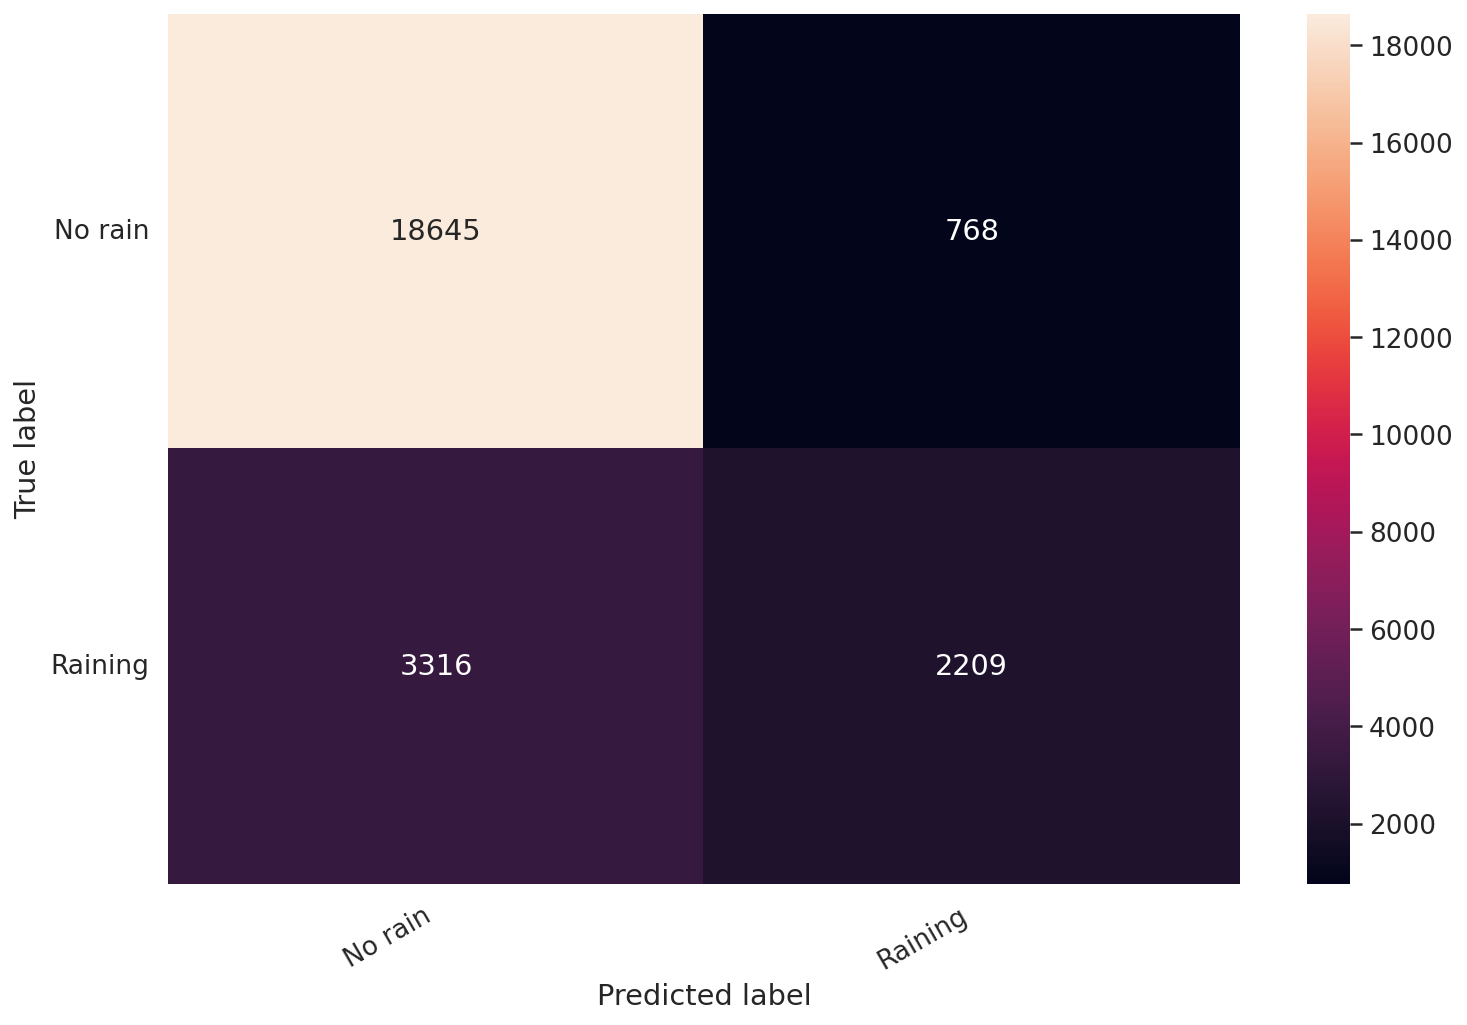

In [28]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

**Se puede ver claramente que no hay que confiar en nuestro modelo cuando dice que va a llover.**

**Haciendo Predicciones**

Probémos nuestro modelo con algunos ejemplos hipotéticos:

In [29]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

Lo siguiente devolverá una respuesta binaria basada en las predicciones del modelo. Probemos:

In [30]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

False

In [31]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True

**Una Consideracion final**:

Modelo Listo para desplegar, aunque dadas las falencias que tiene a la hora de predecir lluvias (los datos estaban desbalanceados en este sentido) no sería recomendable usarlo mucho. A pesar de lo anterior este notebook brinda información valiosa de como construir/entrenar/guardar/trabajar una red neuronal(NN). 
Vale la pena destacar nuevamente **la calidad de los datos con los que se entrene un modelo** para obtener resultados confiables. 